# MLP GAN MNIST

This notebook is a demonstration for a simple GAN training on MNIST by using KnetLayers. Let's get started!

In [ ]:
using Pkg; for p in ("Colors","ImageMagick","Images"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet, KnetLayers, Colors, ImageMagick, Images, Statistics
import Knet: Data
import KnetLayers: arrtype
setoptim!(model,optimizer) = for p in params(model) p.opt=Knet.clone(optimizer) end # Easy optimizer setter
#Data
include(Knet.dir("data","mnist.jl"))

## Discriminator and Generator Networks

Discriminator and Generator networks are defined as `D` and `G` respectively. Loss functions `𝑱d` and `𝑱g` are defined according to the equation X in GAN paper. Sample noise function `𝒩` is a normal distribution. Loss functions are defined according to the equations in Algorithm 1 section of the [paper](https://arxiv.org/abs/1406.2661 "arXiv"). We use a slightly modified generator loss according to [GAN tricks](https://github.com/soumith/ganhacks#2-a-modified-loss-function "GAN Tricks").
$$ J_d = -\frac{1}{m} \sum_{i=1}^{m} log(D(x^{(i)}) + log(1-D(G(z^{(i)})))$$
$$ J_g = -\frac{1}{m} \sum_{i=1}^{m} log(D(G(z^{(i)}))) $$ 

*`𝜀` is used to prevent log functions from resulting NaN values.

In [2]:
global const 𝜀=Float32(1e-8)
𝑱d(D,x,Gz) = -mean(log.(D(x) .+ 𝜀) .+ log.((1+𝜀) .- D(Gz)))/2   #discriminator loss
𝑱g(D,G,z)  = -mean(log.(D(G(z)) .+ 𝜀)) # generator loss          
𝒩(input, batch) = arrtype(randn(Float32, input, batch))  #sample noise

𝒩 (generic function with 1 method)

## Train & Test Function

This `runmodel` function is implementing training procedure described in GAN paper. It first update discriminator with specified optimizer, then update generator network. Same function can be used in test mode by passing `train` argument as false. In the test mode it calculates losses instead of gradients.

In [15]:
function runmodel(D, G, data, 𝞗; dtst=nothing, train=false, saveinterval=20)
    gloss = dloss = total= 0.0; B = 𝞗[:batchsize]    
    if train
        Dprms, Gprms, L = params(D), params(G), 𝞗[:epochs] 
    else
        Dprms, Gprms, L = nothing, nothing, 1
    end
    
    for i=1:L
        for (x,_) in data     
            Gz = G(𝒩(𝞗[:ginp], B)) #Generate Fake Images
            z = 𝒩(𝞗[:ginp], 2B)     #Sample z from Noise

            if train 
                jd = @diff 𝑱d(D, x, Gz)
                for w in Dprms update!(w,grad(jd,w))  end
                jg = @diff 𝑱g(D, G, z)
                for w in Gprms update!(w,grad(jg,w))  end
            else
                jd = 𝑱d(D, x, Gz)
                jg = 𝑱g(D, G, z)
            end          
            dloss += 2B*value(jd); gloss += 2B*value(jg); total += 2B            
        end
        train ? runmodel(D, G, dtst, 𝞗; train=false) : println((gloss/total, dloss/total))
        i % saveinterval == 0 && generate_and_show(D, G, 100, 𝞗)  # save 10 images
    end
end

runmodel (generic function with 1 method)

## Generate and Display

This function generates a random `number` of images and displays them.

In [16]:
function generate_and_show(D,G,number,𝞗)
    Gz    = convert(Array,G(𝒩(𝞗[:ginp], number))) .> 0.5
    Gz    = reshape(Gz, (28, 28, number))
    L     = floor(Int, sqrt(number))
    grid  = []
    for i = 1:L:number
        push!(grid, reshape(permutedims(Gz[:,:,i:i+L-1], (2,3,1)), (L*28,28)))
    end
    display(Gray.(hcat(grid...)))
end

generate_and_show (generic function with 1 method)

## Model&Data Run
We will load MNIST data and initalize our MLP models


In [17]:
𝞗 = Dict(:batchsize=>32,:epochs=>80,:ginp=>256,:genh=>512,:disch=>512,:optim=>Adam(;lr=0.0002))
G = Chain(MLP(𝞗[:ginp], 𝞗[:genh], 784; activation=ELU()), Sigm())
D = Chain(MLP(784, 𝞗[:disch], 1; activation=ELU()), Sigm())
setoptim!(D, 𝞗[:optim]); setoptim!(G, 𝞗[:optim])

In [18]:
xtrn,ytrn,xtst,ytst = mnist()
global dtrn,dtst = mnistdata(xsize=(784,:),xtype=arrtype, batchsize=𝞗[:batchsize]) 

(Data{Tuple{KnetArray{Float32,2},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05 0x0a … 0x06 0x08], 32, 60000, false, 59969, 1:60000, false, (784, Colon()), (60000,), KnetArray{Float32,N} where N, Array{UInt8,1}), Data{Tuple{KnetArray{Float32,2},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 32, 10000, false, 9969, 1:10000, false, (784, Colon()), (10000,), KnetArray{Float32,N} where N, Array{UInt8,1}))

## RUN!

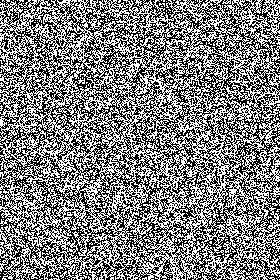

(0.5722909390162199, 0.768760601297403)
(3.4057553081940384, 0.07073348962391417)
(3.397142688433329, 0.23847132234666973)
(2.9691551342988625, 0.21685714395239186)
(2.756654386336987, 0.2122870464809239)
(2.4117400562151885, 0.33032580111653376)
(2.777548285631033, 0.2409664475096342)
(2.6147060554761152, 0.25338952525112873)
(2.880305459101995, 0.24951606689212033)
(3.180207526072478, 0.25275708123659474)
(3.13302750312365, 0.23925155173175228)
(3.316014535151995, 0.26803327719561565)
(3.1806869094188395, 0.22756875237115684)
(2.8200797881835546, 0.22862679492204618)
(2.9647569022117515, 0.22787759012471026)
(2.6657966130819077, 0.23722592874979362)
(2.4521469187278013, 0.31829936066881204)
(2.4357468646306257, 0.26435274618844956)
(2.4456682484119368, 0.30003457884184825)
(2.527069859779798, 0.29419155215892273)


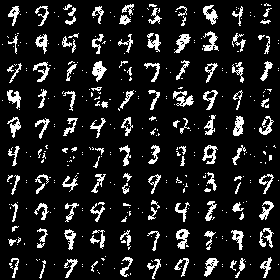

(2.402986457714668, 0.38214738585819036)
(2.630210145925864, 0.3066676637539879)
(2.4224904668636813, 0.3290182557912209)
(3.153582424689562, 0.2777884096766894)
(2.640105568445646, 0.42169772542248934)
(2.603773995851859, 0.4535312555634823)
(1.908068598462985, 0.39881154307379174)
(2.577145365568308, 0.279930268581479)
(2.2274449192560635, 0.3489506610024434)
(2.375471619459299, 0.3407482026288143)
(2.485807037506348, 0.35329968553896135)
(2.494383384784063, 0.3683459114474364)
(2.417684081655282, 0.3572406579191104)
(2.187628781948334, Inf)
(2.3781649665190625, 0.3607304228995091)
(2.280138012690422, 0.35475673106236333)
(2.1411385727234378, 0.36263701310142493)
(2.3116834450226564, 0.3692847735320146)
(2.4566221107275057, 0.3614740110217379)
(2.3920550170617227, 0.3595620662164994)
(

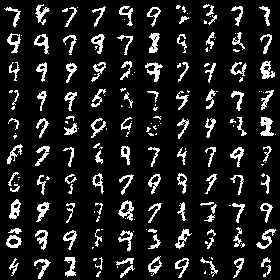

2.431059936300302, 0.3635685803034367)
(2.2566708834507527, 0.352952158699433)
(2.426401366025974, 0.367750232704939)
(2.3152896693119636, 0.33835988420133406)
(2.3610017593854513, 0.3283853048028854)
(2.6063607388581986, 0.4359757798508956)
(2.3501703104911704, 0.3217092222796801)
(2.4712610833155804, 0.33984603594319945)
(2.2627246429522834, 0.35595568747092515)
(2.489331983602964, 0.3469446095614097)
(2.3989882515026975, 0.35407300484486115)
(2.4159208948795614, 0.3431443979438299)
(2.068356841802597, 0.3558525007504683)
(2.72682584860386, 0.28848082376405215)
(2.2811520730073633, 0.3419594733665387)
(2.316829985150924, 0.34027214711293197)
(2.3882960959886894, 0.35275484325411993)
(2.639139641553928, 0.34388566561616385)
(2.2680835796472354, 0.3324660966411615)
(2.4590350962602177, 0.32229469465808225)
(

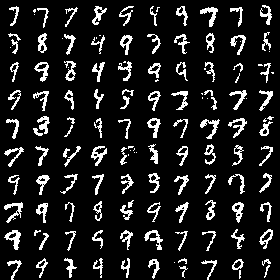

In [19]:
generate_and_show(D, G, 100, 𝞗)
runmodel(D, G, dtst, 𝞗; train=false) # initial losses
runmodel(D, G, dtrn, 𝞗; train=true, dtst=dtst) # training